# Plotting accuracies

In [ ]:
from compvits.scripts.gather_data import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sns.set_style("whitegrid")

In [ ]:
models = ["deit", "dino", "ibot"]

In [ ]:
Ms = [2,3,4,6,8,9,12,16]
#nnd = gather_nearest_neighbor_data("../../logs", models=["deitb"], Ms=[f"M{x}" for x in Ms])
tld = gather_test_linear_data("../../logs/small", models=models, Ms=[f"M{x}" for x in Ms])
#nndf = pd.DataFrame(flatten_nearest_neighbor_data(nnd))
tldf = pd.DataFrame(flatten_test_linear_data(tld))

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,8), sharey=True)
for ax, model in zip(axs, models):
    sns.lineplot(data=tldf[tldf["model"]==model], x="K", y="top1_acc", hue="M", ax=ax)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.set_title(model)
#nndf["min_top1_acc"] = nndf[[f"nn{k}_top1_acc" for k in [10,20,100,200]]].apply(lambda x: min(x), axis=1)
#nndf["max_top1_acc"] = nndf[[f"nn{k}_top1_acc" for k in [10,20,100,200]]].apply(lambda x: max(x), axis=1)
#sns.lineplot(data=nndf, x="K", y="max_top1_acc", hue="M", ax=axs[1])

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20,5), sharey=True)
axs[0].set_ylabel(" ")
axs[0].set_title("nn10")
axs[1].set_title("nn20")
axs[2].set_title("nn100")
axs[3].set_title("nn200")
sns.lineplot(data=nndf, x="K", y="nn10_top1_acc", hue="M", ax=axs[0])
sns.lineplot(data=nndf, x="K", y="nn20_top1_acc", hue="M", ax=axs[1])
sns.lineplot(data=nndf, x="K", y="nn100_top1_acc", hue="M", ax=axs[2])
sns.lineplot(data=nndf, x="K", y="nn200_top1_acc", hue="M", ax=axs[3])

# Sequential

In [17]:
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt

In [16]:
models = ["deit", "dino", "ibot"]

In [5]:
dfs = {}
for model in models:
    with open(f"/home/jan.olszewski/git/vissl/logs/small/sequential_accuracy/{model}/metrics.json") as f:
        data = json.load(f)
    tab = []
    for s, a in data.items():
        k,m,i = [int(x[1:]) for x in s.split("_")[1:]]
        tab.append([str(k), m, i+1, a])
    df = pd.DataFrame(tab)
    df.columns = ["K", "M", "i", "acc"]
    dfs[model] = df

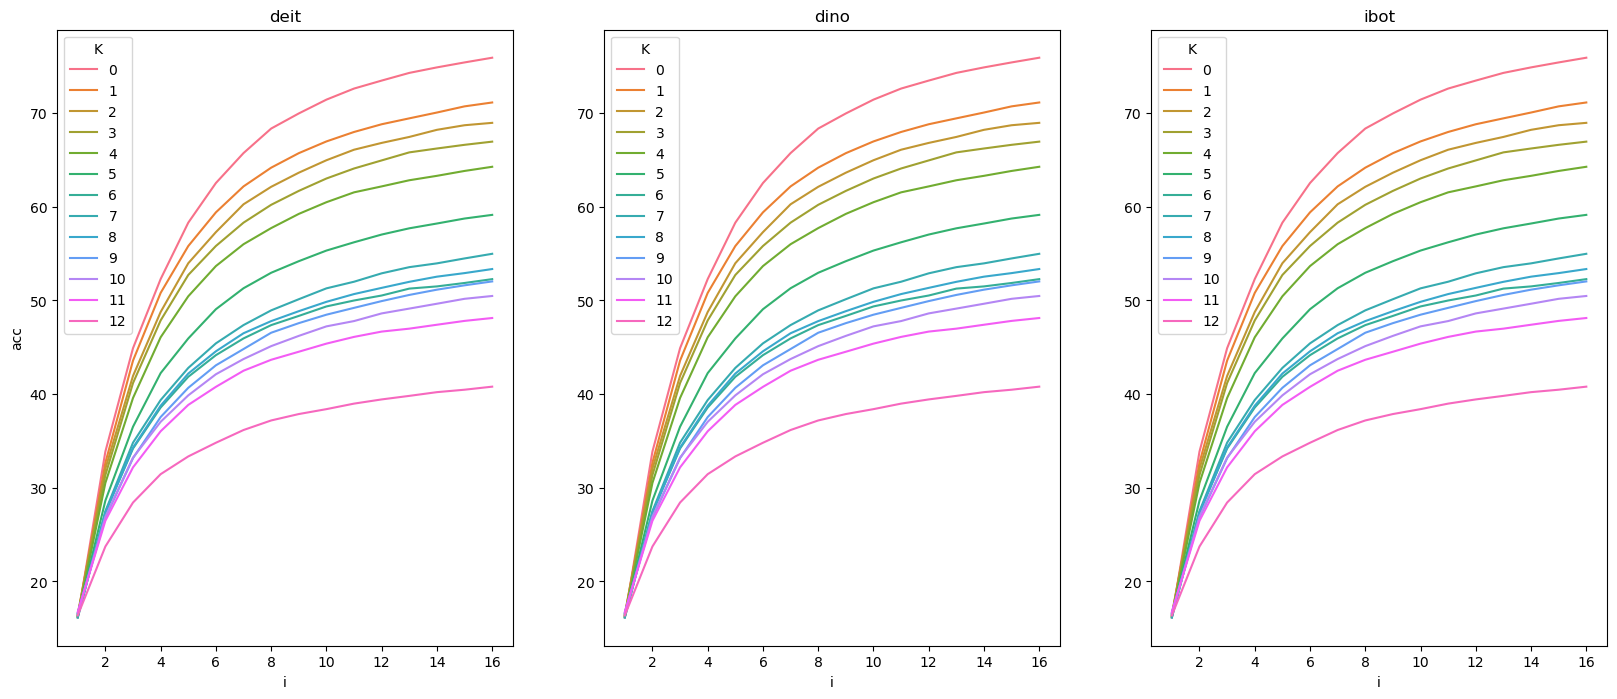

In [20]:
fig, axs = plt.subplots(1,len(models),figsize=(20,8),sharey=True)
for ax, model in zip(axs, models):
    sns.lineplot(df, x = "i", y="acc", hue="K", ax=ax)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.set_title(model)

# Example analysis plot (outdated)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch
import PIL
from torchvision.transforms import Resize

In [ ]:
def get_l2(feats):
    feats = torch.tensor(feats)
    feats = feats.to(device="cuda:0")
    kto0_l2 = (feats[[0],:,:] - feats).norm(dim=-1).mean(dim=-1).detach().cpu().numpy()
    N=1000
    ids = torch.randperm(10000)[:N]
    feats = feats.transpose(0,1)[ids].transpose(0,1)
    ref_l2 = []
    for x in feats:
        ref_l2.append((x[None, :, :] - x[:,None, :]).norm(dim=-1))
    ref_l2 = torch.stack(ref_l2)
    ref_l2_mean = ref_l2.mean()#.mul(1+1/N)
    ref_l2_std = ref_l2.std()
    return kto0_l2, ref_l2_mean.cpu().numpy(), ref_l2_std.cpu().numpy()


def get_cos(feats):
    feats = torch.tensor(feats)
    feats = feats.to(device="cuda:0")
    kto0_cos = (feats[[0],:,:] * feats).sum(dim=-1).div(feats[[0],:,:].norm(dim=-1)).div(feats.norm(dim=-1)).mean(dim=-1).detach().cpu().numpy()
    N=1000
    ids = torch.randperm(10000)[:N]
    feats = feats.transpose(0,1)[ids].transpose(0,1)
    ref_cos = []
    for x in feats:
        ref_cos.append((x[None, :, :] * x[:,None, :]).sum(dim=-1) \
                       .div(x.pow(2).sum(dim=-1)))
    ref_cos = torch.stack(ref_cos)
    ref_cos_mean = ref_cos.mean() #.masked_fill(torch.eye(N, device=x.device, dtype=bool), 0).mean().mul(1+1/N).detach().cpu().numpy())
    ref_cos_std = ref_cos.std()

    return kto0_cos, ref_cos_mean.cpu().numpy(), ref_cos_std.cpu().numpy()

In [ ]:
from vissl.data.ssl_transforms.compvits import CompMasking
cms = {
    "cm_54_54_108_0": [[[9,6], [6,9]], [[9,6], [6,9]]],
    "cm_72_36_108_0": [[[8,9], [9,8], [12,6], [6,12]], [[6,6], [4,9], [9,4], [12, 3], [3, 12]]],
    "cm_72_72_144_0": [[[8,9], [9,8], [6,12], [12,6]], [[8,9], [9,8], [6,12], [12,6]]],
    "cm_96_48_144_0": [[[8,12], [12,8]], [[8,6], [6,8], [4,12], [12,4]]],
    "cm_98_98_196_0": [[[14,7], [7,14]], [[14,7],[7,14]]],
    "cm_140_56_196_0": [[[14,10], [10,14]], [[14,4],[4,14]]],
}
resize = Resize(224)


In [ ]:
def plot(dir, cm, model, axs):
    nn = pd.read_csv(os.path.join(dir, "nearest_neighbor.csv"))
    tl = pd.read_csv(os.path.join(dir, "test_linear.csv"))
    feats = np.load(os.path.join(dir, "feats.npy"))
    sns.lineplot(nn,x=range(0,len(nn)), y="top10_acc1", ax=axs[0][0], label="k=10")
    sns.lineplot(nn,x=range(0,len(nn)), y="top20_acc1", ax=axs[0][0], label="k=20")
    sns.lineplot(nn,x=range(0,len(nn)), y="top100_acc1", ax=axs[0][0], label="k=100")
    sns.lineplot(nn,x=range(0,len(nn)), y="top200_acc1", ax=axs[0][0], label="k=200")
    axs[0][0].set_title("knn evaluation")
    axs[0][0].set_ylabel("Top1 Acc")
    #axs[0][0].set_xlabel("K")
    sns.lineplot(tl,x=range(0,len(tl)), y="test_accuracy_list_meter.top_1.cls1_evalmlp", ax=axs[0][1]   , label="cls1_evalmlp")
    sns.lineplot(tl,x=range(0,len(tl)), y="test_accuracy_list_meter.top_1.cls1_mlp", ax=axs[0][1]       , label="cls1_mlp")
    sns.lineplot(tl,x=range(0,len(tl)), y="test_accuracy_list_meter.top_1.cls4_evalmlp", ax=axs[0][1]   , label="cls4_evalmlp")
    sns.lineplot(tl,x=range(0,len(tl)), y="test_accuracy_list_meter.top_1.cls4_mlp", ax=axs[0][1]       , label="cls4_mlp")
    axs[0][1].set_title("linear evaluation")
    axs[0][1].set_ylabel("Top1 Acc")
    #axs[0][1].set_xlabel("K")
    l2, ref_l2_mean, ref_l2_std = get_l2(feats)
    sns.lineplot(x=range(0,9), y=l2, ax=axs[1][0])
    sns.lineplot(x=range(0,9), y=ref_l2_mean, ax=axs[1][0])
    axs[1][0].fill_between(x = range(9), y1=(ref_l2_mean - 1*ref_l2_std), y2=(ref_l2_mean + 1*ref_l2_std), alpha=0.1, color="red")
    axs[1][0].fill_between(x = range(9), y1=(ref_l2_mean - 2*ref_l2_std), y2=(ref_l2_mean + 2*ref_l2_std), alpha=0.1, color="red")
    axs[1][0].fill_between(x = range(9), y1=(ref_l2_mean - 3*ref_l2_std), y2=(ref_l2_mean + 3*ref_l2_std), alpha=0.1, color="red")
    axs[1][0].set_title("similarity to original feature")
    axs[1][0].set_ylabel("L2 dist")
    axs[1][0].set_xlabel("K")
    cos, ref_cos_mean, ref_cos_std = get_cos(feats)
    sns.lineplot(x=range(0,9), y=cos, ax=axs[1][1])
    sns.lineplot(x=range(0,9), y=ref_cos_mean, ax=axs[1][1])
    axs[1][1].fill_between(x = range(9), y1=(ref_cos_mean - 1*ref_cos_std).clip(0,1), y2=(ref_cos_mean + 1*ref_cos_std).clip(0,1), alpha=0.1, color="red")
    axs[1][1].fill_between(x = range(9), y1=(ref_cos_mean - 2*ref_cos_std).clip(0,1), y2=(ref_cos_mean + 2*ref_cos_std).clip(0,1), alpha=0.1, color="red")
    axs[1][1].fill_between(x = range(9), y1=(ref_cos_mean - 3*ref_cos_std).clip(0,1), y2=(ref_cos_mean + 3*ref_cos_std).clip(0,1), alpha=0.1, color="red")
    axs[1][1].set_title("similarity to original feature")
    axs[1][1].set_ylabel("cos similarity")
    axs[1][1].set_xlabel("K")

    for i in range(2):
        for j in range(2):
            axs[i][j].set_xticks(range(9))

    sampler = CompMasking(masks_shapes=cms[cm]).primary_secondary
    sample_x0, sample_x1 = sampler()
    #heat_x0, heat_x1 = np.zeros_like(sample_x0, dtype=float), np.zeros_like(sample_x1, dtype=float)
    #for _ in range(1000):
    #    x, y = sampler()
    #    heat_x0 += x
    #    heat_x1 += y
    #heat_x0 /= 1000
    #heat_x1 /= 1000
    #sns.heatmap(heat_x0, ax=axs[0][2])
    #sns.heatmap(heat_x1, ax=axs[0][3])
    img = PIL.Image.open("cat.jpg")
    img = resize(img)
    img = np.array(img)
    sample_x0 = np.repeat(np.repeat(sample_x0, 16, 0), 16, 1).reshape(224,224,1)
    sample_x1 = np.repeat(np.repeat(sample_x1, 16, 0), 16, 1).reshape(224,224,1)
    axs[0][2].imshow(img*sample_x0)
    axs[0][2].get_yaxis().set_visible(False)
    axs[0][2].get_xaxis().set_visible(False)
    axs[1][2].imshow(img*sample_x1)
    axs[1][2].get_yaxis().set_visible(False)
    axs[1][2].get_xaxis().set_visible(False)
    

In [ ]:
for root, dirs, files in os.walk("data"):
    if len(dirs) == 0:
        head = root
        head, model = os.path.split(head)
        _, cm = os.path.split(head)
        if cm != "cm_98_98_196_0":
            continue
        fig, axs = plt.subplots(2, 3, figsize=(12,8))
        plot(root, cm, model, axs)


# Visualize divisions

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
from compvits.constants import DIVISION_MASKS_14_14

In [ ]:

division_masks = DIVISION_MASKS_14_14.copy()

In [ ]:
nrow = {2: 1, 3: 1, 4: 2, 6: 2, 8: 2, 9: 3, 12:4, 16: 4}
img_grids = {k: make_grid([torch.Tensor(mask).repeat(3,1,1) for mask in division_masks[k][1]], nrow=nrow[k], pad_value=0.5) for k in division_masks}

In [ ]:
plt.imshow(img_grids[8].permute(1,2,0))